In [2]:
import gym
from gym import spaces
from gym.utils import seeding

In [3]:
import pandas as pd
import numpy as np
import typing
from datetime import datetime

In [4]:
import ray
# Start up Ray. This must be done before we instantiate any RL agents.
ray.init(num_cpus=10, ignore_reinit_error=True, log_to_driver=False)

2020-12-02 15:18:14,684	INFO services.py:1164 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '155.198.195.98',
 'raylet_ip_address': '155.198.195.98',
 'redis_address': '155.198.195.98:63936',
 'object_store_address': '/tmp/ray/session_2020-12-02_15-18-14_086889_130484/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-12-02_15-18-14_086889_130484/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2020-12-02_15-18-14_086889_130484',
 'metrics_export_port': 43874}

In [5]:

def load_data(
    price_source: str, 
    tickers: typing.List[str],
    start: datetime, 
    end: datetime, 
    features: typing.List[str],
):
    """Returned price data to use in gym environment"""
    # Load data
    # Each dataframe will have columns date and a collection of fields
    # TODO: DataLoader from mongoDB
    # Raw price from DB, forward impute on the trading days for missing date
    # calculate the features (log return, volatility)
    if price_source in ["csvdata"]:
        feature_df = []
        for t in tickers:
            df1 = pd.read_csv("csvdata/{}.csv".format(t))
            df1['datetime'] = pd.to_datetime(df1['datetime'])
            df1 = df1[(df1['datetime']>=start) & (df1['datetime']<=end)]
            df1.set_index("datetime",inplace=True)
            selected_features = ['return','tcost'] + features
            feature_df.append(df1[selected_features])
            ref_df_columns = df1[selected_features].columns

    # assume all the price_df are aligned and cleaned in the DataLoader
    merged_df = pd.concat(feature_df, axis=1, join="outer")
    # Imputer missing values with zeros 
    price_tensor = merged_df['return'].fillna(0.0).values
    tcost = merged_df['tcost'].fillna(0.0).values

    return {
        "dates": merged_df.index,
        "fields": ref_df_columns,
        "data": merged_df.fillna(0.0).values,
        "pricedata": price_tensor,
        "tcost": tcost,
    }


In [6]:
from empyrical import max_drawdown, alpha_beta, sharpe_ratio, annual_return
from sklearn.preprocessing import StandardScaler 

class Equitydaily(gym.Env):

    def __init__(self,env_config):
        
        self.tickers = env_config['tickers']
        self.lookback = env_config['lookback']
        self.random_start = env_config['random_start']
        self.trading_days = env_config['trading_days'] # Number of days the algorithm runs before resetting
        # Load price data, to be replaced by DataLoader class
        raw_data = load_data(env_config['pricing_source'],env_config['tickers'],env_config['start'],env_config['end'],env_config['features'])
        # Set the trading dates, features and price data 
        self.dates = raw_data['dates']
        self.fields = raw_data['fields']
        self.pricedata = raw_data['pricedata']
        self.featuredata = raw_data['data']
        self.tcostdata = raw_data['tcost']
        # Set up historical actions and rewards 
        self.n_assets = len(self.tickers) + 1
        self.n_metrics = 2 
        self.n_assets_fields = len(self.fields)
        self.n_features = self.n_assets_fields * len(self.tickers) + self.n_assets + self.n_metrics # reward function
        #self.n_features = self.n_assets_fields * len(self.tickers)
        
        # Set up action and observation space
        # The last asset is cash 
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers)+1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.lookback,self.n_features,1), dtype=np.float32)

        self.reset()

    def step(self, action):
        
        # Trade on Friday 
        # Normalise action space 
        if self.currentdate.weekday() == 4:
            normalised_action = action / np.sum(np.abs(action))
            self.actions = normalised_action
        
        done = False
        # Rebalance portfolio at close using return of the next date
        next_day_log_return = self.pricedata[self.index,:]
        # transaction cost 
        transaction_cost = self.transaction_cost(self.actions,self.position_series[-1])
        
        # Rebalancing 
        self.position_series = np.append(self.position_series, [self.actions], axis=0)
        # Portfolio return 
        today_portfolio_return = np.sum(self.actions[:-1] * next_day_log_return) + np.sum(transaction_cost)
        self.log_return_series = np.append(self.log_return_series, [today_portfolio_return], axis=0)
        
        
        # Calculate reward 
        # Need to cast log_return in pd series to use the functions in empyrical 
        recent_series = pd.Series(self.log_return_series)[-100:]
        rolling_volatility = np.std(recent_series)
        if rolling_volatility > 0:
            self.metric = today_portfolio_return / rolling_volatility 
        else:
            self.metric = 0
        reward = self.metric
        self.metric_series = np.append(self.metric_series, [self.metric], axis=0)
        
        # Check if the end of backtest
        if self.trading_days is None:
            done = self.index >= self.pricedata.shape[0]-2
        else:
            done = (self.index - self.start_index) >= self.trading_days
            
        # Prepare observation for next day
        self.index += 1
        self.observation = self.get_observation()
        self.currentdate = self.dates[self.index-1]        

        return self.observation, reward, done, {}
    
    
    def reset(self):
        self.log_return_series = np.zeros(shape=self.lookback)
        self.metric_series = np.zeros(shape=self.lookback)
        self.position_series = np.zeros(shape=(self.lookback,self.n_assets))
        self.metric = 0    
        if self.random_start:
            num_days = len(self.dates)      
            self.start_index = np.random.randint(self.lookback, num_days - self.trading_days)
            self.index = self.start_index
        else:
            self.start_index = self.lookback
            self.index = self.lookback
        self.actions = np.zeros(shape=self.n_assets)
        self.observation = self.get_observation()
        self.currentdate = self.dates[self.index-1]
        return self.observation
    
    def get_observation(self):
        # Can use simple moving average data here 
        price_lookback = self.featuredata[self.index-self.lookback:self.index,:]
        metrics = np.vstack((self.log_return_series[self.index-self.start_index:self.index-self.start_index+self.lookback], 
                             self.metric_series[self.index-self.start_index:self.index-self.start_index+self.lookback])).transpose()
        positions = self.position_series[self.index-self.start_index:self.index-self.start_index+self.lookback]
        scaler = StandardScaler()
        price_lookback = pd.DataFrame(scaler.fit_transform(price_lookback)).rolling(20,min_periods=1).mean().values
        observation = np.concatenate((price_lookback, metrics, positions), axis=1)
        return observation.reshape((observation.shape[0], observation.shape[1], 1))
    
    # 0.05% and spread to model t-cost for institutional portfolios 
    def transaction_cost(self, new_action, old_action,):
        turnover = np.abs(new_action - old_action) 
        fees = 0.9995 - self.tcostdata[self.index,:]
        fees = np.array(list(fees) + [0.9995])
        tcost = turnover * np.log(fees)
        return tcost 

In [100]:
config = {
    "pricing_source": "csvdata",
    "tickers": [
        "BRK_A",
        "GE_",
        "GOLD_",
        "AAPL_",
        "GS_",
        "T_",
    ],
    "lookback": 200,
    "start": "1995-01-02",
    "end": "2015-12-31",
    "features": [
        "return_volatility_20",
    ],
    'random_start': True, 
    'trading_days':600, 
}

EQ_env = Equitydaily(config)

In [101]:
EQ_env.observation.shape, EQ_env.n_features

((200, 27, 1), 27)

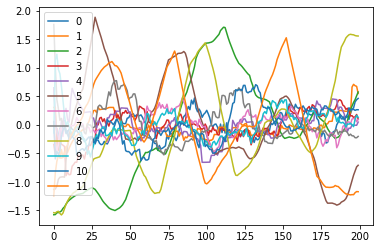

In [102]:
pd.DataFrame(EQ_env.observation[:,:12,0]).plot()

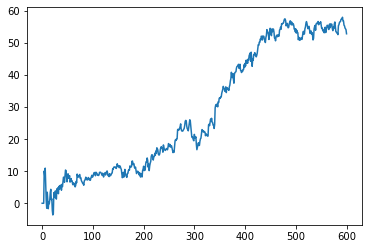

In [103]:
state = EQ_env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()

while not done:
    #action = agent.compute_action(state)
    action = np.array([1,0,0,0,0,0,0])
    state, reward, done, future_price = EQ_env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)

pd.Series(reward_list).cumsum().plot()

PPO policy

In [8]:
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

Instructions for updating:
non-resource variables are not supported in the long term


In [9]:
config = DEFAULT_CONFIG.copy()
config["num_workers"] = 15
config["num_envs_per_worker"] = 5
config["rollout_fragment_length"] = 50
config["train_batch_size"] = 25000
config["batch_mode"] = "complete_episodes"
config["num_sgd_iter"] = 20
config["sgd_minibatch_size"] = 2000
config["model"]["dim"] = 200
config["model"]["conv_filters"] = [[16, [5, 1], 5], [16, [5, 1], 5], [16, [5, 1], 5]]
config[
    "num_cpus_per_worker"
] = 2  # This avoids running out of resources in the notebook environment when this cell is re-executed
config["env_config"] = {
    "pricing_source": "csvdata",
    "tickers": [
        "GOLD_",
    ],
    "lookback": 200,
    "start": "1995-01-02",
    "end": "2015-12-31",
    "features": [
        "return_volatility_20",
        "return_skewness_20",
        "adjvolume_volatility_20",
    ],
    "random_start": True,
    "trading_days": 1000,
}

In [10]:
config

{'num_workers': 15,
 'num_envs_per_worker': 5,
 'rollout_fragment_length': 50,
 'batch_mode': 'complete_episodes',
 'num_gpus': 0,
 'train_batch_size': 25000,
 'model': {'fcnet_hiddens': [256, 256],
  'fcnet_activation': 'tanh',
  'conv_filters': [[16, [5, 1], 5], [16, [5, 1], 5], [16, [5, 1], 5]],
  'conv_activation': 'relu',
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': True,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action_reward': False,
  '_time_major': False,
  'framestack': True,
  'dim': 200,
  'grayscale': False,
  'zero_mean': True,
  'custom_model': None,
  'custom_model_config': {},
  'custom_action_dist': None,
  'custom_preprocessor': None},
 'optimizer': {},
 'gamma': 0.99,
 'horizon': None,
 'soft_horizon': False,
 'no_done_at_end': False,
 'env_config': {'pricing_source': 'csvdata',
  'tickers': ['GOLD_'],
  'lookback': 200,
  'start': '1995-01-02',
  'end': '2015-12-31',
  'features': ['return_volat

Check to see if agents can be trained

In [11]:
agent = PPOTrainer(config, Equitydaily)
best_reward = -np.inf

2020-12-02 15:18:52,178	INFO trainer.py:591 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2020-12-02 15:18:52,179	INFO trainer.py:616 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-12-02 15:18:56,377	WARNING util.py:39 -- Install gputil for GPU system monitoring.


In [12]:
for i in range(2):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward + 10:
        path = agent.save('sampleagent')
        print(path)
        best_reward = result['episode_reward_mean']
        print(best_reward)

2020-12-02 15:19:04,903	WARNING worker.py:1072 -- The actor or task with ID ffffffffffffffffd251967801000000 is pending and cannot currently be scheduled. It requires {CPU: 2.000000} for execution and {CPU: 2.000000} for placement, but this node only has remaining {node:155.198.195.98: 1.000000}, {memory: 55.175781 GiB}, {object_store_memory: 18.994141 GiB}. In total there are 0 pending tasks and 10 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.
2020-12-02 15:19:05,149	INFO (unknown file):0 -- gc.collect() freed 20 refs in 0.1510094478726387 seconds


KeyboardInterrupt: 

In [ ]:
result

In [ ]:
agent.restore('sampleagent/checkpoint_1/checkpoint-1')

In [78]:
for i in range(5):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward + 1:
        path = agent.save('sampleagent')
        print(path)
        best_reward = result['episode_reward_mean']
        print(best_reward)

sampleagent/checkpoint_4/checkpoint-4
-535.9323429076005
sampleagent/checkpoint_5/checkpoint-5
-526.1276376951023
sampleagent/checkpoint_7/checkpoint-7
-522.2019039406775


In [79]:
result

{'episode_reward_max': -415.02074011362794,
 'episode_reward_min': -633.5108483329875,
 'episode_reward_mean': -522.2019039406775,
 'episode_len_mean': 2627.0,
 'episodes_this_iter': 2,
 'policy_reward_min': {},
 'policy_reward_max': {},
 'policy_reward_mean': {},
 'custom_metrics': {},
 'hist_stats': {'episode_reward': [-539.1598334863469,
   -469.06551439816803,
   -562.9823075709035,
   -523.5588877487897,
   -570.4579153419675,
   -549.8358615276551,
   -633.5108483329875,
   -415.02074011362794,
   -460.29247088179636,
   -571.7997117430767,
   -502.9626815458952,
   -470.85495214432393,
   -480.83164749398276,
   -560.4932828399646],
  'episode_lengths': [2627,
   2627,
   2627,
   2627,
   2627,
   2627,
   2627,
   2627,
   2627,
   2627,
   2627,
   2627,
   2627,
   2627]},
 'sampler_perf': {'mean_env_wait_ms': 0.9928205776032585,
  'mean_raw_obs_processing_ms': 0.09451218710168378,
  'mean_inference_ms': 0.8205471140632769,
  'mean_action_processing_ms': 0.08131409539686671}

SAC 

In [25]:
def load_data(
    price_source: str,
    tickers: typing.List[str],
    start: datetime,
    end: datetime,
    features: typing.List[str],
):
    """Returned price data to use in gym environment"""
    # Load data
    # Each dataframe will have columns date and a collection of fields
    # TODO: DataLoader from mongoDB
    # Raw price from DB, forward impute on the trading days for missing date
    # calculate the features (log return, volatility)
    if price_source in ["csvdata"]:
        feature_df = []
        for t in tickers:
            df1 = pd.read_csv("csvdata/{}.csv".format(t))
            df1["datetime"] = pd.to_datetime(df1["datetime"])
            df1 = df1[(df1["datetime"] >= start) & (df1["datetime"] <= end)]
            df1.set_index("datetime", inplace=True)
            selected_features = ["return", "tcost"] + features
            feature_df.append(df1[selected_features])
            ref_df_columns = df1[selected_features].columns

    # assume all the price_df are aligned and cleaned in the DataLoader
    merged_df = pd.concat(feature_df, axis=1, join="outer")
    # Imputer missing values with zeros
    price_tensor = merged_df["return"].fillna(0.0).values
    tcost = merged_df["tcost"].fillna(0.0).values

    return {
        "dates": merged_df.index,
        "fields": ref_df_columns,
        "data": merged_df.fillna(0.0).values,
        "pricedata": price_tensor,
        "tcost": tcost,
    }


from empyrical import max_drawdown, alpha_beta, sharpe_ratio, annual_return
from sklearn.preprocessing import StandardScaler 

class Equitydaily(gym.Env):

    def __init__(self,env_config):
        
        self.tickers = env_config['tickers']
        self.lookback = env_config['lookback']
        self.random_start = env_config['random_start']
        self.trading_days = env_config['trading_days'] # Number of days the algorithm runs before resetting
        # Load price data, to be replaced by DataLoader class
        raw_data = load_data(env_config['pricing_source'],env_config['tickers'],env_config['start'],env_config['end'],env_config['features'])
        # Set the trading dates, features and price data 
        self.dates = raw_data['dates']
        self.fields = raw_data['fields']
        self.pricedata = raw_data['pricedata']
        self.featuredata = raw_data['data']
        self.tcostdata = raw_data['tcost']
        # Set up historical actions and rewards 
        self.n_assets = len(self.tickers) + 1
        self.n_metrics = 2 
        self.n_assets_fields = len(self.fields)
        self.n_features = self.n_assets_fields * len(self.tickers) + self.n_assets + self.n_metrics # reward function
        #self.n_features = self.n_assets_fields * len(self.tickers)
        
        # Set up action and observation space
        # The last asset is cash 
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers)+1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.lookback,self.n_features,1), dtype=np.float32)

        self.reset()

    def step(self, action):
        
        # Trade on Friday 
        # Normalise action space 
        if self.currentdate.weekday() == 4:
            normalised_action = action / np.sum(np.abs(action))
            self.actions = normalised_action
        
        done = False
        # Rebalance portfolio at close using return of the next date
        next_day_log_return = self.pricedata[self.index,:]
        # transaction cost 
        transaction_cost = self.transaction_cost(self.actions,self.position_series[-1])
        
        # Rebalancing 
        self.position_series = np.append(self.position_series, [self.actions], axis=0)
        # Portfolio return 
        today_portfolio_return = np.sum(self.actions[:-1] * next_day_log_return) + np.sum(transaction_cost)
        self.log_return_series = np.append(self.log_return_series, [today_portfolio_return], axis=0)
        
        
        # Calculate reward 
        # Need to cast log_return in pd series to use the functions in empyrical 
        recent_series = pd.Series(self.log_return_series)[-100:]
        rolling_volatility = np.std(recent_series)
        if rolling_volatility > 0:
            self.metric = today_portfolio_return / rolling_volatility 
        else:
            self.metric = 0
        reward = self.metric
        self.metric_series = np.append(self.metric_series, [self.metric], axis=0)
        
        # Check if the end of backtest
        if self.trading_days is None:
            done = self.index >= self.pricedata.shape[0]-2
        else:
            done = (self.index - self.start_index) >= self.trading_days
            
        # Prepare observation for next day
        self.index += 1
        self.observation = self.get_observation()
        self.currentdate = self.dates[self.index-1]        

        return self.observation, reward, done, {}
    
    
    def reset(self):
        self.log_return_series = np.zeros(shape=self.lookback)
        self.metric_series = np.zeros(shape=self.lookback)
        self.position_series = np.zeros(shape=(self.lookback,self.n_assets))
        self.metric = 0    
        if self.random_start:
            num_days = len(self.dates)      
            self.start_index = np.random.randint(self.lookback, num_days - self.trading_days)
            self.index = self.start_index
        else:
            self.start_index = self.lookback
            self.index = self.lookback
        self.actions = np.zeros(shape=self.n_assets)
        self.observation = self.get_observation()
        self.currentdate = self.dates[self.index-1]
        return self.observation
    
    def get_observation(self):
        # Can use simple moving average data here 
        price_lookback = self.featuredata[self.index-self.lookback:self.index,:]
        metrics = np.vstack((self.log_return_series[self.index-self.start_index:self.index-self.start_index+self.lookback], 
                             self.metric_series[self.index-self.start_index:self.index-self.start_index+self.lookback])).transpose()
        positions = self.position_series[self.index-self.start_index:self.index-self.start_index+self.lookback]
        scaler = StandardScaler()
        price_lookback = pd.DataFrame(scaler.fit_transform(price_lookback)).rolling(20,min_periods=1).mean().values
        observation = np.concatenate((price_lookback, metrics, positions), axis=1)
        return observation
    
    # 0.05% and spread to model t-cost for institutional portfolios 
    def transaction_cost(self, new_action, old_action,):
        turnover = np.abs(new_action - old_action) 
        fees = 0.9995 - self.tcostdata[self.index,:]
        fees = np.array(list(fees) + [0.9995])
        tcost = turnover * np.log(fees)
        return tcost 

In [26]:
from ray.rllib.agents.sac import SACTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

In [31]:
config = DEFAULT_CONFIG.copy()
config["num_workers"] = 10
config["num_envs_per_worker"] = 5
config["num_cpus_per_worker"] = 2  # This avoids running out of resources in the notebook environment when this cell is re-executed

config["rollout_fragment_length"] = 20
config["train_batch_size"] = 2500
config["batch_mode"] = "complete_episodes"

config["gamma"] = 0.3
config["lr"] = 0.0001


config["learning_starts"] = 100
config["timesteps_per_iteration"] = 50
config["n_step"] = 5

config["model"]["conv_filters"] = [[16, [5, 1], 5], [16, [5, 1], 5], [16, [5, 1], 5]]

config["Q_model"]["fcnet_hiddens"] = [64, 64]
config["policy_model"]["fcnet_hiddens"] = [64, 64]

config["env_config"] = {
    "pricing_source": "csvdata",
    "tickers": [
        "GOLD_",
        "AAPL_",
    ],
    "lookback": 200,
    "start": "1995-01-02",
    "end": "2015-12-31",
    "features": [
        "return_volatility_20",
        "return_skewness_20",
        "adjvolume_volatility_20",
    ],
    "random_start": True,
    "trading_days": 1000,
}


In [32]:
# Train agent 
agent = SACTrainer(config, Equitydaily)
best_reward = -np.inf

2020-12-03 17:18:20,560	WARNING sac_tf_policy.py:36 -- When not using a state-preprocessor with SAC, `fcnet_hiddens` will be set to an empty list! Any hidden layer sizes are defined via `policy_model.fcnet_hiddens` and `Q_model.fcnet_hiddens`.


(200, 15)
(200, 15)
(200, 15)
(200, 15)
(200, 15)


2020-12-03 17:18:23,822	WARNING util.py:39 -- Install gputil for GPU system monitoring.


In [33]:
for i in range(20):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward + 0.01:
        path = agent.save('sampleagent')
        print(path)
        best_reward = result['episode_reward_mean']
    print(result['episode_reward_mean'])

KeyboardInterrupt: 

In [ ]:
result

Run environment 

In [ ]:
config

In [ ]:
agent = PPOTrainer(config, Equitydaily)

In [ ]:
env = Equitydaily({'pricing_source':'Alpaca_Equity_daily', 'tickers':['SPY','QQQ','SHY','GLD','TLT','EEM'], 'lookback':50, 'start':'2011-01-02', 'end':'2020-12-31'})

In [ ]:
agent.restore('checkpoint_1087/checkpoint-1087')

In [ ]:
state = env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()

while not done:
    #action = agent.compute_action(state)
    action = np.array([0,0,0,0,0,0,1])
    state, reward, done, _ = env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)

pd.Series(env.log_return_series).cumsum().plot()

In [ ]:
pd.Series(reward_list).plot()

In [ ]:
pd.DataFrame(actions)

Run environment for RNN environment

In [ ]:
env = Equitydaily({'pricing_source':'Alpaca_Equity_daily', 'tickers':['SPY','QQQ'], 'lookback':50, 'start':'2018-01-02', 'end':'2020-12-31'})

state = env.reset()
done = False
cum_reward = 0 
actions = list()

rnn_state = agent.get_policy().get_initial_state()

while not done:
    action, rnn_state, _ = agent.compute_action(state,rnn_state)
    #action = np.array([1,-1])
    state, reward, done, _ = env.step(action)
    cum_reward += reward
    actions.append(actions)

pd.Series(env.log_return_series).cumsum().plot()

In [ ]:
max_drawdown(pd.Series(env.log_return_series))

In [ ]:
annual_return(pd.Series(env.log_return_series))

In [ ]:
class Equitydaily_v1(gym.Env):

    def __init__(self,env_config):
        
        self.tickers = env_config['tickers']
        self.lookback = env_config['lookback']
        # Load price data, to be replaced by DataLoader class
        raw_data = load_data(env_config['pricing_source'],env_config['tickers'],env_config['start'],env_config['end'])
        # Set the trading dates, features and price data 
        self.dates = raw_data['dates']
        self.fields = raw_data['fields']
        self.pricedata = raw_data['pricedata']
        self.featuredata = raw_data['data']
        self.tcostdata = raw_data['tcost']
        # Set up historical actions and rewards 
        self.n_assets = len(self.tickers) + 1
        self.n_metrics = 2 
        self.n_assets_fields = len(self.fields)
        self.n_features = self.n_assets_fields * len(self.tickers) + self.n_assets + self.n_metrics # reward function
        
        # Set up action and observation space
        # The last asset is cash 
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers)+1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.lookback,self.n_features), dtype=np.float32)

        self.reset()

        

    def step(self, action):
        
        ## Normalise action space 
        normalised_action = action / np.sum(np.abs(action))
        
        done = False
        # Rebalance portfolio at close using return of the next date
        next_day_log_return = self.pricedata[self.index,:]
        # transaction cost 
        transaction_cost = self.transaction_cost(normalised_action,self.position_series[-1])
        
        # Rebalancing 
        self.position_series = np.append(self.position_series, [normalised_action], axis=0)
        # Portfolio return 
        today_portfolio_return = np.sum(normalised_action[:-1] * next_day_log_return) + np.sum(transaction_cost)
        self.log_return_series = np.append(self.log_return_series, [today_portfolio_return], axis=0)
        
        
        # Calculate reward 
        # Need to cast log_return in pd series to use the functions in empyrical 
        live_days = self.index - self.lookback
        burnin = 250
        recent_series = pd.Series(self.log_return_series)[-100:]
        whole_series = pd.Series(self.log_return_series)
        if live_days > burnin: 
            self.metric = annual_return(whole_series) + 0.5* max_drawdown(whole_series)
        else:
            self.metric = annual_return(whole_series) + 0.5* max_drawdown(whole_series) *live_days / burnin
        reward = self.metric - self.metric_series[-1]
        #reward = self.metric
        self.metric_series = np.append(self.metric_series, [self.metric], axis=0)
        
        # Check if the end of backtest
        if self.index >= self.pricedata.shape[0]-2:
            done = True
            
        # Prepare observation for next day
        self.index += 1
        self.observation = self.get_observation()
            
        return self.observation, reward, done, {'current_price':next_day_log_return}
    
    
    def reset(self):
        self.log_return_series = np.zeros(shape=self.lookback)
        self.metric_series = np.zeros(shape=self.lookback)
        self.position_series = np.zeros(shape=(self.lookback,self.n_assets))
        self.metric = 0                    
        self.index = self.lookback
        self.observation = self.get_observation()
        return self.observation
    
    def get_observation(self):
        # Can use simple moving average data here 
        price_lookback = self.featuredata[self.index-self.lookback:self.index,:]
        metrics = np.vstack((self.log_return_series[self.index-self.lookback:self.index], 
                             self.metric_series[self.index-self.lookback:self.index])).transpose()
        positions = self.position_series[self.index-self.lookback:self.index]
        observation = np.concatenate((price_lookback, metrics, positions), axis=1)
        return observation 
    
    # 0.05% and spread to model t-cost for institutional portfolios 
    def transaction_cost(self,new_action,old_action,):
        turnover = np.abs(new_action - old_action) 
        fees = 0.9995 - self.tcostdata[self.index,:]
        tcost = turnover * np.log(fees)
        return tcost 